In [1]:
import os

from DumpFileLoader import DumpFileLoader
from com import convert_to_com
from diffuse import compute_MSD, compute_diffusion_coefficient

# Ionic Liquids simulation

## Working with output files

### Load the data into the memory

Create an instance of the loader class and pass to the constructor the filepath of the LAMMPS output file.

In [2]:
def create_filepath(output_dirname, filename):
    current_directory = os.getcwd()
    return os.path.join(current_directory, output_dirname, filename)

In [3]:
output_dirname_il = 'dump_files'
filename_il = 'dump.msd.data.lammpstrj'
path_il = create_filepath(output_dirname_il,filename_il)
dump = DumpFileLoader(path_il)

Reading data...
[==================================================] 100.0% Complete
Done!


**Note:** For demonstration purposes the output file has been reduced to only a small excerpt from the original output file (about $\frac{1}{16}$ of original size).

### Examine the output file and simulation properties

Check, what properties are available.

In [4]:
dump.keywords

['id', 'mol', 'type', 'xu', 'yu', 'zu']

Get a property stored in the output file, for instance x-coordinates of the atoms.

The method returns an array, where rows represent consecutive timesteps and columns correspond to particular atoms. 

Shape of every matrix is equal to (n_timesteps x n_atoms).

In [5]:
dump.get_property(name='xu')

array([[ 3.34494,  4.64709,  5.00862, ..., 10.7796 , 10.4966 , 12.119  ],
       [ 3.72086,  4.94313,  5.00453, ..., 11.6035 , 11.0183 , 12.9521 ],
       [ 3.75051,  5.01989,  5.6879 , ..., 11.646  , 11.7183 , 13.5293 ],
       ...,
       [ 9.26553,  9.53225,  8.4591 , ...,  6.95133,  9.04607,  7.51784],
       [ 8.57136,  8.85552,  7.79865, ...,  6.57726,  7.12234,  5.14131],
       [ 7.55631,  8.27237,  7.85658, ...,  6.97524,  7.55401,  5.58372]])

One can request a few properties at once, but then they will be assembled into arrays grouped by the timestep.

The method returns a dictionary with a timestep-array key-value pairs.

In [6]:
# Get the array with selected properties at 0th timestep. Rows of each array correspond to particular atoms and columns represent specific properties.
dump.get_custom_array(property_names=['id','type']).get(0) 

array([[1.0000e+00, 1.0000e+00],
       [2.0000e+00, 2.0000e+00],
       [3.0000e+00, 1.0000e+00],
       ...,
       [1.1998e+04, 1.4000e+01],
       [1.1999e+04, 1.4000e+01],
       [1.2000e+04, 1.4000e+01]])

There is also a convenience method, which returns three spatial coordinates of the atoms at once.

In [7]:
# Columns of the array correspond to x,y,z atomic coordinates
dump.get_coordinates_array().get(0)

array([[ 3.34494 , 51.6558  , 14.1168  ],
       [ 4.64709 , 51.5362  , 13.8074  ],
       [ 5.00862 , 50.3206  , 13.6322  ],
       ...,
       [10.7796  ,  1.34339 , 22.7141  ],
       [10.4966  , -0.585713, 21.9233  ],
       [12.119   ,  0.581047, 21.1432  ]])

### Recognize the molecules populating the studied system

DumpFileLoader class provides a method to recognize molecule types in the system based on the types of atoms, which constitute them. 

The method will work only if the each molecule type consists of disjoint sets of atomic types, i.e. it won't work if type A and type B molecules both contain a type C atom.

The method requires the user to indicate, which types of the atoms correspond to which molecules and (optionally) provide names for these molecules.

In [8]:
# Bmim/Ntf2 are the (shortened) names of ions present in the system
# If the names of the molecules are not provided, the method will automatically name them mol1, mol2, ...
dump.recognize_molecules(mols_by_atom_types=[[1,2,3,4,5,6,7,8,9,10,11,12],[13,14,15,16,17]],molnames=['bmim', 'ntf2'])

This method will internally create two objects of a separate class (MoleculeType), representing a molecule. 

Instances of this class and thus collective properties of these molecules can be accessed with another method from the DumpFileLoader class.

In [9]:
# Get objects representing collections of molecules of particular types
bmim_mol = dump.get_molecule_type('bmim')
ntf2_mol = dump.get_molecule_type('ntf2')

In [10]:
# Exemplary properties
print(f'Types of the atoms in "bmim" type molecule: {bmim_mol.atom_types}')
print(f'Number of "ntf2" molecules in the system: {ntf2_mol.nummols}')

Types of the atoms in "bmim" type molecule: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Number of "ntf2" molecules in the system: 300


## Computations

### Molecular Center-of-Mass (COM)

COM of a collection of molecules can be computed with a function called convert_to_com() from "com" package.

The function takes an instance of DumpFileLoader class as an argument and modifies it in-place, so the new properties becomes available, namely, spatial coordinates of the molecules.

To determine the COM of the collection of point particles, the knowledge of the mass of each particle is necessary. The function doesn't require to specify the exact mapping beteween the atom type and the mass, but only if LAMMPS output files contained the "element" property. If this is not the case, then the dictionary with types and masses must be provided. In this case, only the second approach is feasible.

In [12]:
# Conversion with explicit type-to-mass mapping
# key: atom type, value: mass
TYPE_MASS_MAP = {
    1 : 14.007,
    2 : 12.011, 
    3 : 12.011, 
    4 : 12.011,
    5 : 1.008, 
    6 : 12.011, 
    7 : 1.008, 
    8 : 1.008, 
    9 : 12.011, 
    10 : 12.011, 
    11 : 1.008, 
    12 : 12.001,
    13 : 12.001, 
    14 : 18.998, 
    15 : 32.066, 
    16 : 14.000,
    17 : 15.999
}

convert_to_com(dump_obj=dump, type_to_mass_map=TYPE_MASS_MAP)

Computing COM for molecules of type: bmim
[==================================================] 100.0% Complete
Computing COM for molecules of type: ntf2
[==================================================] 100.0% Complete


New properties are now available.

In [13]:
# x-coordinate of center-of-mass of "bmim" type molecules at different timesteps
bmim_mol.get_property('COM_x')

array([[ 4.73627316,  9.51567366, 49.74607202, ...,  4.51353512,
         3.15239237, 34.37975716],
       [ 4.794112  ,  9.4775941 , 50.27156235, ...,  5.21096495,
         2.82895607, 34.40709327],
       [ 5.43377311,  9.39680091, 49.70253523, ...,  5.95625701,
         2.54295986, 35.15429271],
       ...,
       [ 9.12005669, 11.17132652, 49.81019071, ...,  4.44348585,
         4.75230141, 32.36748976],
       [ 8.5478359 , 10.85251582, 50.04375468, ...,  4.0803734 ,
         3.9954628 , 31.98672228],
       [ 8.23961716, 10.90107774, 49.19767655, ...,  3.48880359,
         3.60053005, 31.9045971 ]])

In [14]:
# y-coordinate of center-of-mass of "bmim" type molecules at different timesteps
ntf2_mol.get_property('COM_y')

array([[18.60247009, 35.55398619, 30.67612932, ..., 15.17217033,
        48.0819595 , -1.34222687],
       [18.06583964, 35.78571356, 30.31571683, ..., 14.61555347,
        47.64379476, -1.61553866],
       [18.89926567, 35.72912265, 29.79019837, ..., 15.63878333,
        47.79759638, -0.8722287 ],
       ...,
       [16.61636395, 30.36172599, 30.30868843, ..., 17.23400848,
        44.39131352,  1.34704694],
       [15.21338696, 30.84712675, 31.06287901, ..., 16.31415774,
        44.28523817,  1.1949276 ],
       [16.00823733, 31.20191614, 30.80599118, ..., 16.80992105,
        44.18859033,  1.26480308]])

### Mean-Square-Displacement (MSD)

Mean-square-displacement of a collection of molecules can be computed with a function called compute_MSD() from "diffuse" package.

The function takes an instance of MoleculeType class as an argument.

For more effective use of the simulation data, the MSD is computed using half of available simulation time. This allows to use different timesteps as reference points (origins), relative to which the MSD is computed. The separation of succesive time origins can be controlled with origin_step_interval parameter. For example, if  origin_step_interval=10, the MSD will be computed with respect to the molecular coordinates at 0th, 10th, 20th, ... timestep.

In [15]:
# as_key=True indicates, that the result will be stored as an attribute of the "bmim" object
compute_MSD(moltype_obj=bmim_mol, origin_step_interval=10, as_key=True)
compute_MSD(moltype_obj=ntf2_mol, origin_step_interval=10, as_key=True)

MSD computed at different timesteps (rows) relative to successive time origins (columns) is now available as a separate property.

In [16]:
bmim_mol.get_property('MSD')[:5]

array([[1.62113262, 1.75816815, 1.72128133, 1.68288179],
       [2.60381004, 2.37221966, 2.207438  , 2.26664253],
       [3.17929162, 2.81605136, 3.10109807, 3.00220839],
       [3.35303378, 3.19171788, 3.8366876 , 3.26772588],
       [4.14804025, 3.73398913, 3.94287522, 3.69262895]])

MSDs computed with respect to different time origins can be plotted as a function of simulation time.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_MSD_vs_time(moltype: DumpFileLoader.MoleculeType):
    fig, ax = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
    fig.suptitle(f'Plot of MSD vs simulation time for {moltype.name} molecule type')

    timestep_length = moltype.timesteps[1] / 1000
    MSD = moltype.get_property('MSD')
    n_origins = MSD.shape[1]
    time_interval = np.arange(1, MSD.shape[0] + 1) * timestep_length

    for reference_timestep in range(n_origins):
        ax[0].plot(time_interval, MSD[:,reference_timestep], label=f'{reference_timestep + 1}')

    for axes in ax:
        axes.set_xlabel('t (ps)', labelpad=10)
        axes.set_ylim([0,14])

    ax[0].set_ylabel('MSD $\mathregular{(\u00c5^2)}$', labelpad=10)
    ax[0].set_title('')
    ax[0].legend(title='Time origin')
    
    ax[1].plot(time_interval, MSD.mean(axis=1), color='tab:purple', label='mean')
    ax[1].tick_params(axis='y',length=0)
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0)

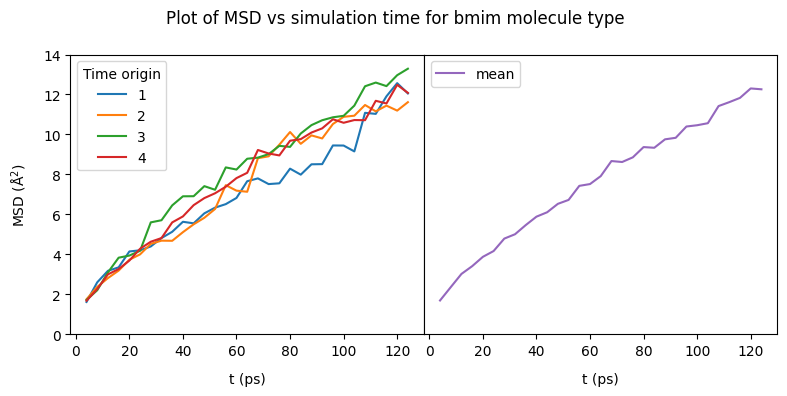

In [18]:
plot_MSD_vs_time(bmim_mol)

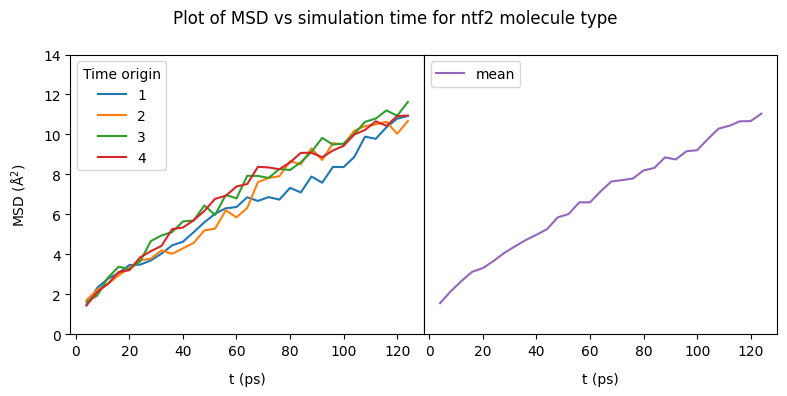

In [19]:
plot_MSD_vs_time(ntf2_mol)

**Note:** Because this data is a fragment of a larger file, the simulation time is quite short (~120 ps). Actual computations of dynamical properties of these compounds (ionic liquids) require much longer timespan (a few nanoseconds).

### Diffusion coefficients

The diffusion coefficient of molecules of particular type can be computed using a function called compute_diffusion_coefficient() from "diffuse" package.

This function uses the following relation:

$D = \frac{1}{6t} \lim_{t\to\infty} MSD(t)$

And utilizes the estimate the slope of the MSD(t) curve to compute the diffusion coefficient. The MSD used for computations is the average with respect to different time origins.

The function takes MoleculeType object as an argument and requires that the MSD property is available for given type of a molecule. The output includes the diffusion coefficient, the estimate of the slope of MSD(t) curve and the standard error of the slope. 

The function allows to specify two additional parameters - start_time and end_time - which in turn allow to determine the part of MSD vs time curve used for computations. necessary as a significant amount of time is needed for the molecules to reach the "diffusive regime", where the slope of the curve becomes approximately constant [Alavi,2020].

\
Alavi, S. Molecular Simulations, Fundamentals and Practice, **2020**, p. 248-252, Wiley-VCH Verlag GmbH & Co. KGaA

In [20]:
# Start_time and end_time are the indices of particular timesteps
# Index = (real simulation time / timestep) - 1 -> (40000 fs / 4000) fs = 9
D_bmim, D_bmim_slope, D_bmim_std = compute_diffusion_coefficient(bmim_mol)
print("Bmim diffusion coefficient: {:0.2e} m^2/s, slope of MSD(t) curve: {:0.2e} Angstrom^2/s and std of the slope {:0.2e} Angstrom^2/s".format(D_bmim,D_bmim_slope,D_bmim_std))

Bmim diffusion coefficient: 1.42e-10 m^2/s, slope of MSD(t) curve: 8.50e-05 Angstrom^2/s and std of the slope 1.63e-06 Angstrom^2/s


## Save your work

DumpFileLoader class comes with two methods, which allow to serialize and deserialize the instances of the class to binary files in order to preserve the their state and prevent the necessity to load large output files again.

In [21]:
# Save the state
dump.save_dump_state(filename='output_saved')

The object has been saved to: output_saved.pkl


In [22]:
# Restore the object
dump_restored = DumpFileLoader.load_saved_state('./output_saved.pkl')

In [23]:
# All previously computed properties are still there
bmim_restored = dump_restored.get_molecule_type('bmim')
bmim_restored.get_property('MSD')[:5]

array([[1.62113262, 1.75816815, 1.72128133, 1.68288179],
       [2.60381004, 2.37221966, 2.207438  , 2.26664253],
       [3.17929162, 2.81605136, 3.10109807, 3.00220839],
       [3.35303378, 3.19171788, 3.8366876 , 3.26772588],
       [4.14804025, 3.73398913, 3.94287522, 3.69262895]])